In [1]:
# Definitions and functions
%matplotlib inline
from __future__ import division
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob
from __future__ import division
# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print('Computer: ' + comp_name)

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))


import soundtools as st
from bci.core import expstruct as et
from bci.core import kwik_functions as kwkf
from bci.core.file import h5_functions as h5f
from bci import synthetic as syn
from bci import unitmeta as um
from bci import stimalign as sta

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp
#from basic_viewing.structure import kwik_functions as kwf
from decoder import linear as ld


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.debug('all modules loaded')

Computer: passaro


In [2]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
syn_sess = 2
# bird = 'z020'
# sess = 'day-2016-06-03'

exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')
kwik_file = et.open_kwik(bird, sess)
kwd_file = et.open_kwd(bird, sess)

In [5]:
# Neural data
shank = 0
shank_chans = prb_par['channel_groups'][shank]['channels']
all_neural_chans = exp_par['channel_config']['neural']
#m_starts = kwkf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())
#m_starts = m.get_start()
all_units = kwkf.list_units(kwik_file, group=shank, sorted=False)
units_list = [Unit(clu, kwik_file=kwik_file) for clu in all_units.clu]

# this returns a numpy recarray with cols:
# group: site group (electrode shank)
# clu: cluster number
# qlt: sorting quality: 1 is MUA, 2 is well isolated (by default, only these 2 qlt's are returned)
# For instance, see all the clusters that are either mua or good units.
print(all_units['clu'])
one_unit = units_list[4]
unit_times, unit_recs = one_unit.get_time_stamps()

#plt.plot(unit_times)


[ 0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52 53
 54 55 56 57 58 59  6 60 61 62 63  7  8  9]


In [269]:
from streamtools import streams as st
from threadtools import threadedfunction as td

reload(st)
def collect_frames_array(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames_array = []
    for i_rec, rec in enumerate(recs):
        starts_from_rec = starts[recs_list==rec]
        logger.info("Rec {0}, {1} events ...".format(rec, starts_from_rec.size))
        stream_obj = st.H5Data(h5f.get_data_set(kwd_file, rec),
                               s_f,
                               chan_list=chan_list,
                               dtype=np.float)
        valid_starts = starts_from_rec[(starts_from_rec > 0) 
                                 & (starts_from_rec + span < stream_obj.n_samples)]
        if valid_starts.size < starts_from_rec.size:
            logger.warn('Some frames were out of bounds and will be discarded')
            logger.warn('will collect only {0} events...'.format(valid_starts.size))
        rec_frames = stream_obj.apply_repeated(valid_starts, span, lambda x: x)
        all_frames_array.append(rec_frames)
    logger.info('Done collecting')
    return np.concatenate(all_frames_array, axis=0)

reload(st)

def get_unit_spikes(the_unit, kwd_file, chan_list, before=20, after=20):
    s_f = the_unit.sampling_rate

    valid_times = the_unit.time_samples[the_unit.time_samples > before]
    
    valid_recs = the_unit.recordings[the_unit.time_samples > before]
    
    if valid_times.size < the_unit.time_samples.size:
            logger.warn('Some frames were out of left bounds and will be discarded')
            logger.warn('will collect only {0} events...'.format(valid_times.size))
            
    return collect_frames_array(valid_times - before, 
                                      before + after, 
                                      s_f, 
                                      kwd_file, 
                                      valid_recs, 
                                      chan_list)


def get_principal_channels(unit, projectors=3):
    unit_path = os.path.split(os.path.abspath(unit.kwik_file.filename))[0]
    all_features = np.load(os.path.join(unit_path, 'pc_features.npy'))
    all_clusters = np.load(os.path.join(unit_path, 'spike_templates.npy'))
    pc_ind = np.load(os.path.join(unit_path, 'pc_feature_ind.npy'))
    
    this_clu_n = unit.clu
    # average across all the pc values of this cluster
    clu_feat = all_features[np.where(all_clusters.flatten()==unit.clu)[0], :, :]
    clu_mean_feat = np.abs(np.mean(clu_feat, axis=0))
    
    # larger projections
    main_feat = (np.fliplr(np.argsort(clu_mean_feat, axis=1))[:,:projectors])
    p_p = main_feat.reshape([1, -1], order='F').flatten()
    indexes = np.unique(p_p, return_index=True)[1]
    indexes.sort()
    principal_projections = p_p[indexes]
    
    # channels projecting onto larger features
    principal_channels = pc_ind[unit.clu][principal_projections]
    
    return principal_channels, principal_projections

def save_unit_spikes(unit, spikes_array):
    unit_path = os.path.split(os.path.abspath(unit.kwik_file.filename))[0]
    file_folder = os.path.join(unit_path, 'unit_waveforms')
    et.mkdir_p(file_folder)
    file_path = os.path.join(file_folder, 'unit_{:03d}.npy'.format(unit.clu))
    logger.info('Saving unit {0} in file {1}'.format(unit.clu, file_path))
    return np.save(file_path, spikes_array)

def get_all_spikes(unit_list, kwd_file, before=20, after=20):
    for unit in unit_list:
        logger.info('Unit clu_n {}'.format(unit.clu))
        chans_list = get_principal_channels(unit, projectors=4)[0]
        spikes = get_unit_spikes(unit, kwd_file, chans_list, before=before, after=after)
        save_unit_spikes(unit, spikes)

        
def get_unit_folder(unit):
    return os.path.split(os.path.abspath(unit.kwik_file.filename))[0]

def load_unit_waveforms(unit):
    folder = get_unit_folder(unit)
    f_name = 'unit_{:03d}.npy'.format(unit.clu)
    return np.load(os.path.join(folder, 'unit_waveforms', f_name))

def get_avg_wave(unit):
    return np.mean(load_unit_waveforms(unit), axis=0)

def get_unit_main_chan(unit):
    a_w_f = get_avg_wave(unit)
    main_chan = np.argmax(np.ptp(avg_spikes, axis=0))
    main_chan_absolute = get_principal_channels(unit)[0][main_chan]
    return main_chan, main_chan_absolute

def get_unit_main_wave(unit):
    ch = get_unit_main_chan(unit)[0]
    return load_unit_waveforms(unit)[:,:,ch]

def get_unit_ptp(unit):
    wf_main = get_unit_main_wave(unit)
    all_ptp = wf_main.ptp(axis=1)
    return np.median(all_ptp), np.std(all_ptp)
        
def get_all_unit_widths(unit):
    logger.info('Getting width of all spikes from clu {}'.format(unit.clu))
    wf_main = get_unit_main_wave(unit)
    wf_samples = wf_main.shape[1]
    mid_points = np.min(wf_main, axis=1) + np.ptp(wf_main, axis=1)/2.
    mid_points_array = np.reshape(np.repeat(mid_points, wf_samples), [-1, wf_samples])
    x, y = np.where(np.diff((wf_main>mid_points_array),1))
    widths = []
    for i in np.unique(x):
        zero_xings = y[x==i]
        if zero_xings.size>1:
            widths.append(np.max(np.diff(y[x==i])))
    
    return np.array(widths)

def get_unit_widths(unit):
    widths = get_all_unit_widths(unit)
    return np.median(widths), np.std(widths)

def all_unit_widths(units_list):
    logger.info('Getting widths of {} units'.format(len(units_list)))
    return np.vstack([np.array(get_unit_widths(u)) for u in units_list])

def all_unit_ptp(units_list):
    logger.info('Getting heights of {} units'.format(len(units_list)))
    return np.vstack([np.array(get_unit_ptp(u)) for u in units_list])


In [6]:
#Debuggings: 
# p_chan, p_proj = get_principal_channels(units_list[32], projectors=4)        
# get_all_spikes(units_list, kwd_file)
# other_spikes = get_unit_spikes(units_list[32], kwd_file, all_neural_chans)
# save_unit_spikes(units_list[32], other_spikes)

In [201]:
log_path = fn['folders']['ss']
log_file = 'unit_collection.log'
log_file_path = os.path.join(log_path, log_file)


#handler = logging.StreamHandler()
handler = logging.FileHandler(log_file_path)
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s (%(threadName)-10s) %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
threads = []

collect_units = td.threadedFunction(args=(get_all_spikes,
                                    units_list[:23],
                                    kwd_file)
                                    )
collect_units.start()
threads.append(collect_units)

2016-12-06 15:31:27,731 threadtools.threadedfunction INFO     Starting function get_all_spikes in thread threadedFunction-4
2016-12-06 15:31:27,753 root         INFO     Unit clu_n 0
2016-12-06 15:31:28,371 root         INFO     Collecting 5 recs...
2016-12-06 15:31:28,374 root         INFO     Rec 0, 3632 events ...
2016-12-06 15:31:29,775 root         INFO     Rec 1, 3311 events ...
2016-12-06 15:31:31,263 root         INFO     Rec 2, 1765 events ...
2016-12-06 15:31:31,813 root         INFO     Rec 3, 2576 events ...
2016-12-06 15:31:33,088 root         INFO     Rec 4, 115260 events ...
2016-12-06 15:32:54,415 root         INFO     Done collecting
2016-12-06 15:32:54,592 root         INFO     Saving unit 0 in file /mnt/cube/earneodo/bci_zf/ss_data/z007/day-2016-09-10/unit_waveforms/unit_000.npy
2016-12-06 15:32:57,212 root         INFO     Unit clu_n 1
2016-12-06 15:32:57,752 root         INFO     Collecting 5 recs...
2016-12-06 15:32:57,755 root         INFO     Rec 0, 117 events .

In [12]:
a_unit = units_list[23]
a_unit.clu

3

In [13]:
a_unit = units_list[23]
chan_list =  get_principal_channels(a_unit, projectors=3)[0]

rec = 2
s_f = a_unit.get_sampling_rate()
samples = a_unit.time_samples[a_unit.recordings==rec]
recs = a_unit.recordings[a_unit.recordings==rec]
raw_table = st.H5Data(h5f.get_data_set(kwd_file, rec),
                               s_f,
                               chan_list=chan_list,
                               dtype=np.float)

all_frames = collect_frames_array(samples - 20, 40, 
                                  s_f, kwd_file, recs, chan_list)


2016-12-06 13:06:39,478 root         INFO     Collecting 1 recs...
2016-12-06 13:06:39,480 root         INFO     Rec 2, 364 events ...


AssertionError: 

In [36]:
u = get_unit_spikes(a_unit, kwd_file, chan_list, before=20, after=20)

2016-12-06 13:26:18,236 root         WARNING  Some frames were out of left bounds and will be discarded
2016-12-06 13:26:18,239 root         WARNING  will collect only 68358 events...
2016-12-06 13:26:18,243 root         INFO     Collecting 5 recs...
2016-12-06 13:26:18,245 root         INFO     Rec 0, 1070 events ...


IOError: Can't read data (Wrong b-tree signature)

In [230]:
log_path = fn['folders']['ss']
log_file = 'width_collection.log'
log_file_path = os.path.join(log_path, log_file)


#handler = logging.StreamHandler()
handler = logging.FileHandler(log_file_path)
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s (%(threadName)-10s) %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)
threads = []


collect_widths = td.threadedFunction(args=(all_unit_widths,
                                    units_list)
                                    )
collect_widths.start()
threads.append(collect_widths)

2016-12-06 16:41:14,885 threadtools.threadedfunction INFO     Starting function all_unit_widths in thread threadedFunction-5
2016-12-06 16:41:14,918 root         INFO     Getting width of all spikes from clu 0


In [247]:
u_h = all_unit_ptp(units_list[:5])

In [248]:
u_h.astype(np.float)

array([[ 1595.        ,   330.26562629],
       [  425.        ,  1650.96014564],
       [  963.        ,   384.59404681],
       [ 2241.        ,   716.28559205],
       [ 1760.        ,   433.39201352]])

In [238]:
some_units = all_units[:5]
some_units

rec.array([(0, 0, 3), (0, 1, 3), (0, 10, 3), (0, 11, 3), (0, 12, 3)], 
          dtype=[('group', '<i8'), ('clu', '<i8'), ('qlt', '<i8')])

In [255]:
n_units = some_units.size
feat_dt = np.dtype([('w', np.float, 1), ('w_std', np.float, 1), ('h', np.float, 1), ('h_std', np.float, 1)])
all_feats = np.recarray(n_units, dtype=feat_dt)
all_feats['w'] = u_w.astype(float)[:,0]
all_feats['w_std'] = u_w.astype(float)[:,1]
all_feats['h'] = u_h.astype(float)[:,0]
all_feats['h_std'] = u_h.astype(float)[:,1]

import numpy.lib.recfunctions as rfn
total_units = rfn.merge_arrays((some_units, all_feats), asrecarray=True, flatten=True)

In [266]:
def all_units_features(units_rec, kwik_file, write=True, path=None):
    units_list = [Unit(clu, kwik_file=kwik_file) for clu in units_rec.clu]
    n_units = units_rec.size
    logger.info('Will compute features of {} units'.format(n_units))
    u_h = all_unit_ptp(units_list)
    u_w = all_unit_widths(units_list)
    
    feat_dt = np.dtype([('w', np.float, 1), 
                        ('w_std', np.float, 1), 
                        ('h', np.float, 1), 
                        ('h_std', np.float, 1)]
                       )
    all_feats = np.recarray(n_units, dtype=feat_dt)
    all_feats['w'] = u_w.astype(float)[:,0]
    all_feats['w_std'] = u_w.astype(float)[:,1]
    all_feats['h'] = u_h.astype(float)[:,0]
    all_feats['h_std'] = u_h.astype(float)[:,1]
    total_units = rfn.merge_arrays((units_rec, all_feats), asrecarray=True, flatten=True)
    if write:
        path = get_unit_folder(units_list[0]) if path is None else path
        np.save(os.path.join(path, 'units_features.npy'), total_units)
    return total_units
    
rec_feat = all_units_features(all_units[4:7], kwik_file)

2016-12-06 17:55:39,810 root         INFO     Will compute features of 3 units
2016-12-06 17:55:41,402 root         INFO     Getting width of all spikes from clu 12
2016-12-06 17:56:07,976 root         INFO     Getting width of all spikes from clu 13
2016-12-06 17:56:08,521 root         INFO     Getting width of all spikes from clu 14


In [274]:
def load_features(bird, sess):
    fn = et.file_names(bird, sess)
    path = et.file_names(bird, sess)['folders']['ss']
    return np.load(os.path.join(path, 'units_features.npy'))

u_f = load_features(bird, sess)

In [296]:
rec_feat

rec.array([(0, 12, 3, 6.0, 3.036061805767721, 1760.0, 433.3920135175748),
 (0, 13, 3, 12.0, 6.902951901763023, 452.0, 1152.9606683706488),
 (0, 14, 3, 12.0, 7.368826380071477, 649.0, 1688.6430251644624)], 
          dtype=[('group', '<i8'), ('clu', '<i8'), ('qlt', '<i8'), ('w', '<f8'), ('w_std', '<f8'), ('h', '<f8'), ('h_std', '<f8')])

In [305]:
def sess_unit_features(bird, sess, shank_list=None, write=True, path=None, sorted=False):
    logger.info('Gonna get spike features of all units from bird {0} sess {1}'.format(bird, sess))
    fn = et.file_names(bird, sess)
    kwik_file = et.open_kwik(bird, sess)
    
    # Neural data
    if shank_list is not None:
        raise NotImplementedError('Kilosort doesnt use shanks, and I still didnt do this for klusta')
    else:
        shank = 0
        
    all_units = kwkf.list_units(kwik_file, group=shank, sorted=sorted)
    all_unit_features = all_units_features(all_units, kwik_file, write=write, path=path)
    return all_unit_features
    


In [306]:
feat_thread = td.threadedFunction(args=(sess_unit_features, bird, sess))
feat_thread.start()
threads.append(feat_thread)


2016-12-06 18:48:56,633 threadtools.threadedfunction INFO     Starting function sess_unit_features in thread threadedFunction-7
2016-12-06 18:48:56,640 root         INFO     Gonna get spike features of all units from bird z007 sess day-2016-09-10
2016-12-06 18:49:01,286 root         INFO     Will compute features of 64 units
2016-12-06 18:49:01,289 root         INFO     Getting heights of 64 units
2016-12-06 18:49:50,093 root         INFO     Getting widths of 64 units
2016-12-06 18:49:50,096 root         INFO     Getting width of all spikes from clu 0
2016-12-06 18:51:27,620 root         INFO     Getting width of all spikes from clu 1
2016-12-06 18:51:29,269 root         INFO     Getting width of all spikes from clu 10
2016-12-06 18:59:35,644 root         INFO     Getting width of all spikes from clu 11
2016-12-06 18:59:37,354 root         INFO     Getting width of all spikes from clu 12
2016-12-06 19:00:03,455 root         INFO     Getting width of all spikes from clu 13
2016-12-06 1

(array([  3.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
          7.,   0.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,
          0.,  14.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,
          0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([  4.  ,   4.17,   4.34,   4.51,   4.68,   4.85,   5.02,   5.19,
          5.36,   5.53,   5.7 ,   5.87,   6.04,   6.21,   6.38,   6.55,
          6.72,   6.89,   7.06,   7.23,   7.4 ,   7.57,   7.74,   7.91,
          8.08,   8.25,   8.42,   8.59,   8.76,   8.93,   9.1 ,   9.27,
          9.44,   9.61,   9.78

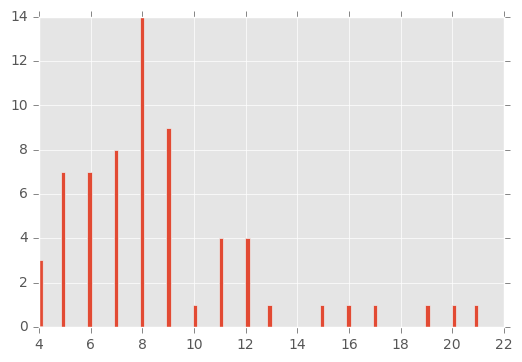

In [357]:
spk_data = load_features(bird, sess)
#plt.hist(spk_data['h'])
plt.hist(spk_data['w'], bins=100)

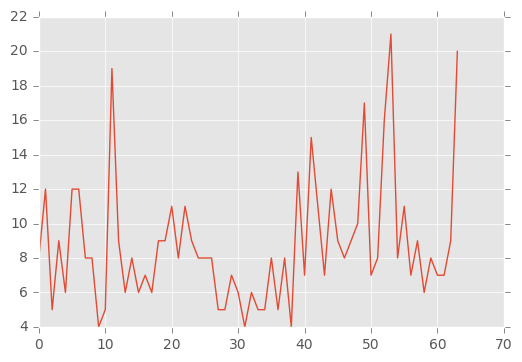

In [314]:
plt.plot(spk_data['w'])

In [348]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    ax.set_xlim(-before_ms, after_ms)
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

def plot_waveform(x, before_ms, after_ms, s_f, ax=None):
    span_before = np.zeros(np.int(before_ms/1000. * s_f))
    span_before[:] = np.nan
    span_after = np.zeros(np.int(after_ms/1000. * s_f) - x.size)
    waveform_plot = np.insert(x, 0, span_before)
    waveform_plot = np.insert(span_after, 0, waveform_plot)
    waveform_t_plot = np.arange(waveform_plot.size)*1000./s_f
    if ax is None:
        raster_fig = plt.figure()
        ax = raster_fig.add_axes([0, 0, 1, 1])
    ax.plot(waveform_plot)
    ax.set_xlim(0, waveform_plot.size)
    ax.plot((span_before.size, span_before.size), (np.min(waveform_plot), np.max(waveform_plot)), 'k--')
    return ax

def plot_one_raster(unit_clu):
    # instance a Unit object
    unit = Unit(unit_clu, kwik_file=kwik_file)
    # get the spike times (in sample units)
    unit.get_time_stamps()
    # get the sampling rate of the recording
    s_f = unit.sampling_rate
    #get a raster for this unit around a window of [-2, 4] sec after each stimulus onset
    before_ms = 1000
    after_ms = 1600
    start_points = m_starts - np.int(s_f * before_ms/1000.) #start_points has to be in sample units
    rs = unit.get_raster(start_points, before_ms + after_ms, span_is_ms=True, return_ms=True)
    # the raster is an n_trial * m array (where m can be sample or ms).
    # in each row, it contains the timestamps (in samples or ms) of spikes relative to the beginning of the trial
    # plot the raster
    b = np.outer((np.arange(rs.shape[0]) + 1), np.ones(rs.shape[1]))
    plt.figure(unit_clu)
    plt.scatter(rs, b, marker='|', rasterized=True)
    plt.xlim(0, before_ms + after_ms)
    plt.show
    
class VizUnit():
    def __init__(self, all_units, pattern_chunk, event):
        print all_units.size
        self.unit = None
        self.raster = None
        self.clu = all_units['clu']
        self.all_units = all_units
        self.is_good = Checkbox()
        self.fig = None
        self.fig_width = 1
        self.fig_ax = {}
        self.pattern_chunk = pattern_chunk
        self.pattern = pattern_chunk.data.reshape(pattern_chunk.data.size,)
        self.before_ms = 200
        self.after_ms = 800
        self.start_points = None
        self.s_f = pattern_chunk.sound.s_f
        self.spectr = None
        self.event = None
        #display(self.is_bout)
        
        self.init_event(event)
        self.init_fig()
        
    def show(self, i):
        i_unit = i
        self.select_unit(i_unit)
        print 'selected unit {0}, clu{1}'.format(i_unit, self.unit.clu)
        ax1 = self.fig_ax['raster']
        ax2 = self.fig_ax['histogram']
        ax1.cla()
        ax2.cla()
        rast, ax1 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, ax=ax1)
        rast, ax2 = plot_raster(sparse_raster(self.raster), t0=self.before_ms, bin_size=5, ax=ax2)
        display(self.fig)
    
    def select_unit(self, i_unit):
        unit_clu = self.all_units['clu'][i_unit]
        self.unit = Unit(unit_clu, kwik_file=kwik_file)
        self.raster = self.unit.get_raster(self.start_points, self.before_ms + self.after_ms, 
                                           span_is_ms=True, return_ms=True)
    
    def init_event(self, event):
        self.event = event
        m_starts = kwkf.apply_rec_offset(kwik_file, self.event.get_start(), self.event.get_rec())
        self.start_points = m_starts - np.int(self.s_f * self.before_ms/1000.)
        
    def init_fig(self):
        self.fig = plt.figure()
        self.fig_ax['raster'] = self.fig.add_axes([0,.3,self.fig_width,0.3])
        self.fig_ax['histogram'] = self.fig.add_axes([0,.6,self.fig_width,0.3])
        self.fig_ax['spectrogram'] = self.fig.add_axes([0,0,self.fig_width,0.2])
        self.fig_ax['synthesis'] = self.fig.add_axes([0,.2,self.fig_width,0.1])
        for ax in self.fig_ax.itervalues():
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        self.update_spectrogram()
        #self.update_synth_plot()

    def update_spectrogram(self):
        ax = self.fig_ax['spectrogram']
        m_chunk = self.pattern_chunk
        self.spectr, ax = plot_spectrogram(m_chunk.data.reshape(m_chunk.data.size,), 
                                           self.before_ms, self.after_ms, m_chunk.sound.s_f, 
                                           ax=ax, 
                                           n_window = 192, n_overlap=192-1, scaling='spectrum')
    def update_synth_plot(self):
        ax = self.fig_ax['synthesis']
        ax = plot_waveform(alpha[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        ax = plot_waveform(beta[192:,], self.before_ms, self.after_ms, m_chunk.sound.s_f, ax=ax)
        
        
        
    def bout_checked(self, bc):
#         print "bout checked"
#         print bc['new']
#         print self.motiff
        self.candidates.set_value(self.motiff, 'bout', bc['new'])
    # inspect the result

In [349]:
spk_data['clu'][0]

0

In [350]:
# Show the rasters
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
m_length = m_chunk.samples
m_starts = kwkf.apply_rec_offset(kwik_file, m.get_start(), m.get_rec())

In [351]:
spk_data[spk_data['w']>10].size

15

selected unit 4, clu9


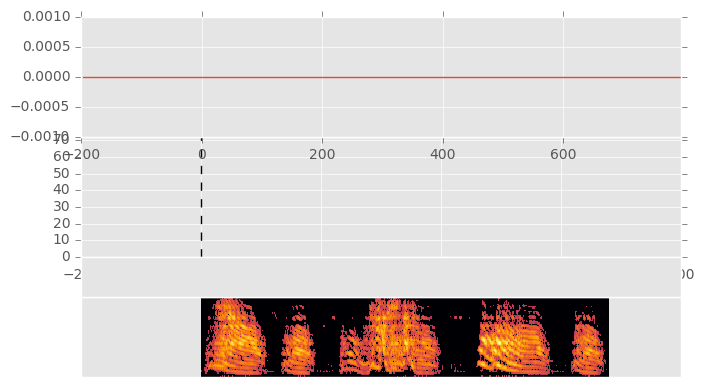

In [356]:
selected_units = spk_data[(spk_data['w']>15) & (spk_data['w']<30)]
vu = VizUnit(selected_units, m_chunk, m)
widgets.interact(vu.show, i=(0, selected_units.size-1, 1))